<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/experimental-push/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Failed to set memory growth:", e)


Memory growth enabled for GPU


In [2]:
!pip install tensorflow
!pip install isic-cli
!pip install kaggle
!pip install imblearn
!pip install tensorflow
!pip install opencv-python-headless
!pip install scikit-image
!pip install pywavelets
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.7 MB/s eta 0:00:00


In [3]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=dGtPHbdwTS845StFpMe8XAVGLECKnH&code_challenge=eUYmeoL20cO7qUkZpw36KtuW4nVyAEl5vJYHpnuLxiE&code_challenge_method=S256
enter the code shown in your browser: V70Vnq769A2m6088O6TvrBaupg1Oq5
Success!


In [4]:
!isic collection list

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test                          │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training                      │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017: Validation                    │ True   │ True   │ True   │ None            │
│ 64  │ Challenge 2018: Task 1-2: Test                │ True   │ True   │ True   │ None    

Step 2: Query the Dataset
Endpoints: Use the API endpoints to query the dataset. Common operations include listing available images, retrieving image metadata, and downloading images.
Filtering: Utilize query parameters to filter the dataset based on your criteria, such as diagnosis, image type, or other metadata.

In [5]:
import requests
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage import exposure, io
from glob import glob
from imblearn.over_sampling import SMOTE
from pathlib import Path
from google.colab import drive
from PIL import Image

In [6]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Comment out if already running

In [7]:
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")

In [8]:
!kaggle datasets download -d andrewmvd/isic-2019

100% 9.10G/9.10G [08:57<00:00, 17.0MB/s]
100% 9.10G/9.10G [08:57<00:00, 18.2MB/s]


In [9]:
!unzip -q isic-2019.zip


In [27]:
metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
# Define the new base path for the images
base_path = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

# Create the full image paths
metadata['image_path'] = metadata['image'].apply(lambda x: base_path / f"{x}.jpg")

# Example of how to display the first few image paths
print(metadata[['image', 'image_path']].head())

          image                                         image_path
0  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4  ISIC_0000001  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...


<ipython-input-27-1c578a8e213b>:1: DtypeWarning: Columns (8,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')


Load the metadata

and

Explore the Metadata CSV: Load the metadata.csv files for training, test, and validation sets to understand the structure and types of data available. This step is crucial for preprocessing and feature selection.

In [28]:
metadata['image_path'].head()

0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object

In [29]:
# Drop the specified columns
metadata.drop(columns=['copyright_license', 'attribution'], inplace=True)
# Rename the column
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
metadata.drop_duplicates(inplace=True)
metadata.head()

,image,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,melanocytic,nevus_type,patient_id,personal_hx_mm,sex,image_path
0,ISIC_0000000,55.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4,ISIC_0000001,30.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
8,ISIC_0000002,60.0,upper extremity,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
12,ISIC_0000003,30.0,upper extremity,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
16,ISIC_0000004,80.0,posterior torso,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...


In [30]:
metadata.shape

(25331, 18)

In [31]:
# Load the data from the file into a DataFrame
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')

# Display the first few rows of the DataFrame
ground_truth.shape

(25331, 10)

In [32]:
image_dir = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata.shape

(25331, 28)

In [33]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [34]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              22989 non-null  float64
 12  anatom_site_general     21374 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [35]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)
full_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              25331 non-null  float64
 12  anatom_site_general     25331 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [36]:
# Sample DataFrame
data = {
    'image_path_x': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path_y': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path': ['path1.jpg', 'path2.jpg', 'path4.jpg']  # Notice the discrepancy in the last row
}
df = full_metadata

# Step 1: Consolidate columns into one
df['consolidated_path'] = df.apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) == 1 else None, axis=1)

# Step 2: Identify discrepancies
df['is_discrepant'] = df.apply(lambda x: len(x.dropna().unique()) != 1, axis=1)

# Step 3: Count discrepancies
discrepancy_count = df['is_discrepant'].sum()

# Step 4: Report discrepancies
discrepancy_report = df[df['is_discrepant']]

print("Number of discrepancies:", discrepancy_count)
print("Discrepancy report:")
print(discrepancy_report[['image_path_x', 'image_path_y', 'image_path', 'consolidated_path']])


Number of discrepancies: 25331
Discrepancy report:
                                            image_path_x  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
3      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
4      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
...                                                  ...   
25326  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25327  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25328  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25329  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25330  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   

                                            image_path_y  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_20

In [37]:
import pandas as pd

# Define a function to convert PosixPath to string and extract the last part of the paths
def detail_discrepancies(row):
    # Convert PosixPath to string and then get the last 30 characters of each path
    x_end = str(row['image_path_x'])[-30:]
    y_end = str(row['image_path_y'])[-30:]
    path_end = str(row['image_path'])[-30:]

    if x_end != y_end or x_end != path_end:
        return f"X vs Y: {x_end} != {y_end}, X vs Path: {x_end} != {path_end}"
    return None

# Apply this function to a new column
full_metadata['discrepancy_details'] = full_metadata.apply(detail_discrepancies, axis=1)

# Filter to show only rows with discrepancies and limit the output
discrepancy_details = full_metadata[full_metadata['discrepancy_details'].notna()].head(10)

print("Detailed discrepancies (first 10 cases focusing on path endings):")
print(discrepancy_details[['image_path_x', 'image_path_y', 'image_path', 'discrepancy_details']])


Detailed discrepancies (first 10 cases focusing on path endings):
                                         image_path_x image_path_y  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
17  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
18  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
19  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
20  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
21  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
22  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
23  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
24  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
25  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   

                                           image_path  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
17  /content/ISIC_2019_Training_Input/ISIC_2019_T

In [38]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general','benign_malignant', 'sex'])


In [39]:
anatom_site_columns = [col for col in full_metadata.columns if col.startswith('anatom_site_general_')]
benign_malignant_columns = [col for col in full_metadata.columns if col.startswith('benign_malignant_')]

print("One-hot encoded columns for 'anatom_site_general':")
print(anatom_site_columns)

print("\nOne-hot encoded columns for 'benign_malignant':")
print(benign_malignant_columns)


One-hot encoded columns for 'anatom_site_general':
['anatom_site_general_anterior torso', 'anatom_site_general_head/neck', 'anatom_site_general_lateral torso', 'anatom_site_general_lower extremity', 'anatom_site_general_oral/genital', 'anatom_site_general_palms/soles', 'anatom_site_general_posterior torso', 'anatom_site_general_unknown', 'anatom_site_general_upper extremity']

One-hot encoded columns for 'benign_malignant':
['benign_malignant_benign', 'benign_malignant_indeterminate/benign', 'benign_malignant_malignant']


In [42]:
# Rename the one-hot encoded 'benign_malignant' columns
full_metadata.rename(columns={
    'benign_malignant_benign': 'benign',
    'benign_malignant_indeterminate/benign': 'indeterminate_benign',
    'benign_malignant_malignant': 'malignant'
}, inplace=True)

# Sum the 'indeterminate_benign' and 'malignant' columns to create a single 'malignant' column
full_metadata['malignant'] = full_metadata['indeterminate_benign'] + full_metadata['malignant']

# Convert any values greater than 1 back to 1 (if there's any overlapping)
full_metadata['malignant'] = full_metadata['malignant'].clip(upper=1)

# Drop the now unnecessary 'indeterminate_benign' column as it has been merged into 'malignant'
full_metadata.drop(columns='indeterminate_benign', inplace=True)

# Verify the changes
print(full_metadata[['benign', 'malignant']].head())
full_metadata.info()


KeyError: 'indeterminate_benign'

In [44]:
# Replace True and False with 1 and 0 respectively
full_metadata.replace({True: 1, False: 0}, inplace=True)

# Drop the specified columns
columns_to_drop = ['diagnosis', 'nevus_type','patient_id', 'dermoscopic_type', 'diagnosis_confirm_type', 'image_path', 'image_type', 'image_path_x', 'image_path_y', 'lesion_id']
full_metadata.drop(columns_to_drop, axis=1, inplace=True)

# Perform Label Encoding for the specified columns
label_encoder = LabelEncoder()
for column in ['concomitant_biopsy', 'family_hx_mm', 'melanocytic', 'personal_hx_mm', 'discrepancy_details', 'consolidated_path']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])

full_metadata = full_metadata.set_index('image')

# Displaying the modified DataFrame
print(full_metadata.head())


KeyError: "['diagnosis', 'nevus_type', 'patient_id', 'dermoscopic_type', 'diagnosis_confirm_type', 'image_path', 'image_type', 'image_path_x', 'image_path_y', 'lesion_id'] not found in axis"

In [45]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   MEL                                  25331 non-null  float64
 2   NV                                   25331 non-null  float64
 3   BCC                                  25331 non-null  float64
 4   AK                                   25331 non-null  float64
 5   BKL                                  25331 non-null  float64
 6   DF                                   25331 non-null  float64
 7   VASC                                 25331 non-null  float64
 8   SCC                                  25331 non-null  float64
 9   UNK                                  25331 non-null  float64
 10  age_approx                           25331 non-null  float64
 11  clin_size_long_diam_mm      

need to create a new method of image paths, due to data


In [46]:
# Load your DataFrame
# full_metadata = pd.read_csv('path_to_your_csv.csv')  # Assuming DataFrame is loaded

# Directory containing the images
directory_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

# List all files in the directory and subdirectories
all_files = glob(os.path.join(directory_path, '**', '*'), recursive=True)

# Function to find a matching file
def find_matching_file(image_name):
    # Possible filenames to search for
    possible_filenames = [
        os.path.join(directory_path, f"{image_name}.jpg"),
        os.path.join(directory_path, f"{image_name}_downsampled.jpg")
    ]

    # Check for existence of possible files
    for file_path in possible_filenames:
        if file_path in all_files:
            return file_path
    return None  # If no file is found

# Apply the function to create a new column with the matched file paths
full_metadata['image_path'] = full_metadata['image'].apply(find_matching_file)

# Check for rows where no file was found
missing_files = full_metadata[full_metadata['image_path'].isnull()]

# Output results
print(f"Number of missing files: {len(missing_files)}")
if not missing_files.empty:
    print("Sample rows with missing files:")
    print(missing_files[['image', 'image_path']].head())  # Adjust to display more if needed


Number of missing files: 0


###Augmentation Using Multiple Studies and ChatGPT4

After creating the initial dual pipeline model, and subsequent retraining using augmented data the best outcome we had been able to get was a low 70's% with some heavy bias according to the confusion matrix and ROC scores.  Next, we used a study on studies around this subject to isolate the best models used in this field [Machine Learning and Deep Learning Methods for Skin Lesion Classification and Diagnosis: A Systematic Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8391467/).  

After reading this study we took to CHATGPT 4.0 and went into its research professional bot, and asked it to analyze the conclusion of the study and produce the best models, as well as the best model that it could ascertain from the internet itself.  the result was the following three classification and prediction setups:
1. [Integrated design of deep features fusion for localization and classification of skin cancer](https://www.sciencedirect.com/science/article/abs/pii/S0167865519303630)
2. [Diagnosis of melanoma from dermoscopic images using a deep depthwise separable residual convolutional network](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/iet-ipr.2018.6669)
3. [Machine Learning and Deep Learning Methods for Skin Lesion Classification and Diagnosis: A Systematic Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8391467/)

The next step was to load the abstracts of each of these studies into the AI CHATGPT4's model called 'Code Pilot' and ask it the following prompt:

*'Im going to drop 3 different abstracts from 3 AI and ML studies on skin lesion classifications. can you analyze the 3 studies, and tell me if there is any approach to a new method built on the framework of these ground breaking methods?'*

The following code is an amalgam of ChatGPT4's Code Pilot, these ground breaking studies and our responses to the hundreds of errors we encountered allong the way ✨

In [48]:

def create_augmented_data_generator():
    data_gen_args = {
        'rotation_range': 20,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }
    return ImageDataGenerator(**data_gen_args)

augment_data_gen = create_augmented_data_generator()


In [49]:
import tensorflow as tf

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image

def load_and_preprocess_data(df, batch_size=32, augment=False, binary_classification=False):
    image_paths = df['image_path'].values

    def load_and_preprocess_data(df, batch_size=32, augment=False, binary_classification=False):
      image_paths = df['image_path'].values

    if binary_classification:
        labels = df[['benign', 'malignant']].values
        labels = labels.dot([1, 0]).astype(float)
    else:
        labels = df[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].values.astype(float)
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    image_label_ds = tf.data.Dataset.zip((path_ds, label_ds))

    def preprocess_and_augment(image_path, label):
        image = preprocess_image(image_path)
        if augment:
            image = tf.numpy_function(func=augment_data_gen.random_transform, inp=[image], Tout=tf.float32)
        return image, label

    dataset = image_label_ds.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Usage example for binary classification
train_dataset_binary = load_and_preprocess_data(full_metadata, augment=True, binary_classification=True)

# Usage example for multi-class classification
train_dataset_multi_class = load_and_preprocess_data(full_metadata, augment=True, binary_classification=False)



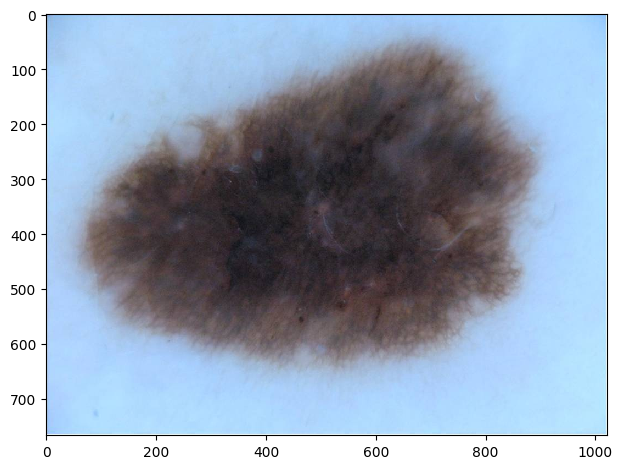

In [50]:
unprocessed_image = ('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg')
io.imshow(unprocessed_image)
io.show()

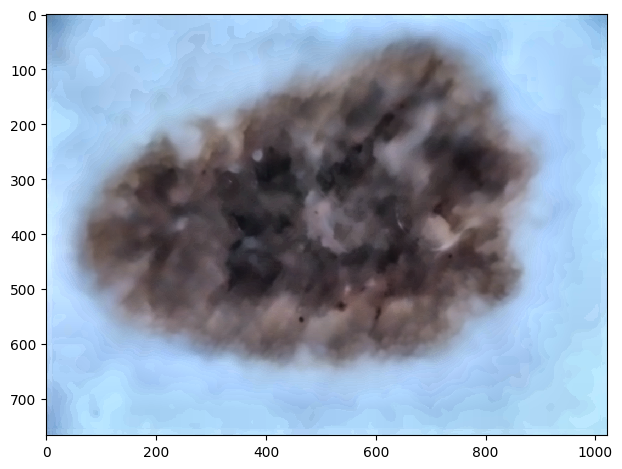

In [51]:
def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at the path: {image_path}")

    # Convert from BGR to RGB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Non-Local Means Denoising
    image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # Convert image to LAB color space to apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))

    # Convert back to RGB color space
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return final_img

# Example usage
try:
    processed_image = preprocess_image('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg')
    # Display the image using skimage's imshow function
    io.imshow(processed_image)
    io.show()
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")



In [ ]:
import cv2
import numpy as np
import pywt
from skimage.filters import threshold_otsu
from skimage import io

def segment_image(image):
    # Ensure the input image is in RGB format
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be RGB.")

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply 2D Wavelet Transform using Biorthogonal wavelets
    coeffs2 = pywt.dwt2(gray_image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2

    # Apply Otsu's thresholding to the approximation coefficients
    threshold_value = threshold_otsu(LL)
    segmented_image = LL > threshold_value

    return segmented_image

# Assume 'processed_image' is already defined as shown in your previous example.
try:
    segmented_image = segment_image(processed_image)
    # Display the segmented image using skimage's imshow function
    io.imshow(segmented_image, cmap='gray')
    io.show()
except ValueError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during the segmentation process: {e}")



In [53]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

def extract_features(image_path):
    # Load the pre-trained VGG16 model without the fully connected layers
    model = VGG16(weights='imagenet', include_top=False)

    # Load and preprocess the image
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_data = keras_image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Extract features
    vgg16_features = model.predict(img_data)
    return vgg16_features

# Example usage
try:
    features = extract_features('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg')
    print("Extracted feature shape:", features.shape)
except Exception as e:
    print(f"An error occurred: {e}")



1/1 [==============================] - 2s 2s/step
Extracted feature shape: (1, 7, 7, 512)


In [54]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Load your metadata; ensure 'image' column exists with image IDs
metadata = full_metadata.copy()

# Define the base path where images are stored
base_path = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

# Function to find image paths considering possible suffixes and extensions
def find_image_path(base_path, image_id):
    suffixes = ['', '_downsampled']  # Add other suffixes as needed
    extensions = ['.jpg', '.jpeg', '.png']
    for suffix in suffixes:
        for ext in extensions:
            potential_path = base_path / f"{image_id}{suffix}{ext}"
            if potential_path.exists():
                return str(potential_path)
    return None  # If no file is found

# Applying the function to each image ID in the DataFrame with progress visualization
metadata['image_path'] = [find_image_path(base_path, img_id) for img_id in tqdm(metadata['image'], desc='Resolving Image Paths')]

# Optionally, check for and report any missing image paths
missing_images = metadata['image_path'].isnull().sum()
if missing_images > 0:
    print(f"Warning: {missing_images} images not found.")

Resolving Image Paths: 100%|██████████| 25331/25331 [00:00<00:00, 108873.47it/s]


In [55]:
import cv2
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def load_and_preprocess_image_rbg (image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at the path: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at: {image_path}")

    image = cv2.resize(image, (224, 224))  # Resize to fit the model input
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

def preprocess_all_data(metadata):
    base_path = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')
    image_data = []
    errors = 0

    # Loop through each file in the metadata DataFrame
    for filename in tqdm(metadata['image'], desc="Loading and processing images"):
        full_path = base_path / f"{filename}.jpg"
        try:
            img = load_and_preprocess_image_rbg(str(full_path))
            image_data.append(img)
        except Exception as e:
            print(e)
            errors += 1
            continue

    if errors == len(metadata):
        raise Exception("All images failed to load. Please check file paths and filenames.")

    # Labels are already one-hot encoded in the DataFrame
    labels = metadata[['benign', 'malignant']].values  # Extract OHE labels directly
    return np.array(image_data), metadata, np.array(labels)

# Use try-except to handle any errors during data processing
try:
    image_data, metadata, labels = preprocess_all_data(metadata)
    print("Data processed successfully.")
    print(f"Total images processed: {len(image_data)}")

    # Split the data into training, validation, and test sets
    image_train, image_temp, labels_train, labels_temp = train_test_split(
        image_data, labels, test_size=0.3, random_state=42, stratify=labels)
    image_val, image_test, labels_val, labels_test = train_test_split(
        image_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)
except Exception as e:
    print(f"An error occurred: {e}")


Loading and processing images: 100%|██████████| 25331/25331 [05:48<00:00, 72.64it/s]


Data processed successfully.
Total images processed: 25331


In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def create_dual_output_model(metadata_shape, num_binary_classes, num_multiclass_classes):
    # Image input
    image_input = Input(shape=(224, 224, 3), name='image_input')
    base_model = VGG16(weights='imagenet', include_top=False)
    base_model.trainable = False  # Freeze the convolutional base
    x_image = base_model(image_input)
    x_image = GlobalAveragePooling2D()(x_image)

    # Metadata input
    metadata_input = Input(shape=(metadata_shape,), name='metadata_input')
    x_metadata = Dense(64, activation='relu')(metadata_input)

    # Concatenate both inputs
    combined_features = Concatenate()([x_image, x_metadata])
    x = Dense(256, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)

    # Binary classification output for benign/malignant
    output_binary = Dense(num_binary_classes, activation='sigmoid', name='output_binary')(x)

    # Multiclass classification output for conditions
    output_multiclass = Dense(num_multiclass_classes, activation='softmax', name='output_multiclass')(x)

    model = Model(inputs=[image_input, metadata_input], outputs=[output_binary, output_multiclass])
    return model

gpt_model = create_dual_output_model(metadata_shape=10, num_binary_classes=1, num_multiclass_classes=8)
print(gpt_model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['image_input[0][0]']         
                                                          8                                       
                                                                                                  
 metadata_input (InputLayer  [(None, 10)]                 0         []                            
 )                                                                                                
                                                                                              

In [57]:
for layer in gpt_model.layers:
    print(layer.name)

image_input
vgg16
metadata_input
global_average_pooling2d
dense
concatenate
dense_1
dropout
dense_2
output_binary
output_multiclass


In [58]:
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weighted_bce = tf.reduce_mean(weights * bce)
        return weighted_bce
    return loss


In [59]:
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Extracting indices where y_true is 1 for one-hot encoded labels
        idx = tf.argmax(y_true, axis=-1)
        weights = tf.gather(tf.constant(list(class_weights.values())), idx)
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weighted_cce = tf.reduce_mean(weights * cce)
        return weighted_cce
    return loss


In [60]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'df' is your DataFrame containing the labels
# For binary classification
binary_labels = full_metadata[['benign', 'malignant']].values
binary_classes = np.array([0, 1])
binary_weights = compute_class_weight('balanced', classes=binary_classes, y=binary_labels.dot([0, 1]).astype(int))
binary_class_weights = dict(zip(binary_classes, binary_weights))

# For multiclass classification
multiclass_labels = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].values
multiclass_classes = np.arange(multiclass_labels.shape[1])
multiclass_weights = compute_class_weight('balanced', classes=multiclass_classes, y=np.argmax(multiclass_labels, axis=1))
multiclass_class_weights = dict(zip(multiclass_classes, multiclass_weights))

print("Binary class weights:", binary_class_weights)
print("Multiclass class weights:", multiclass_class_weights)


Binary class weights: {0: 0.5979369275800208, 1: 3.052663292359605}
Multiclass class weights: {0: 0.7002156125608138, 1: 0.24593203883495146, 2: 0.9528663857959675, 3: 3.652104959630911, 4: 1.2066977896341464, 5: 13.248430962343097, 6: 12.515316205533598, 7: 5.041998407643312}


In [63]:
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    """ Custom loss function for binary classification with class weights. """
    def loss(y_true, y_pred):
        weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(weights * bce)
    return loss

def weighted_categorical_crossentropy(class_weights):
    """ Custom loss function for multiclass classification with class weights. """
    def loss(y_true, y_pred):
        idx = tf.argmax(y_true, axis=-1)
        weights = tf.gather(tf.constant(list(class_weights.values())), idx)
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(weights * cce)
    return loss

# Define class weights directly here as needed
class_weights_binary = {0: 0.5979369275800208, 1: 3.052663292359605}
class_weights_multiclass = {0: 0.7002156125608138, 1: 0.24593203883495146,
                            2: 0.9528663857959675, 3: 3.652104959630911,
                            4: 1.2066977896341464, 5: 13.248430962343097,
                            6: 12.515316205533598, 7: 5.041998407643312
                            }

# Assign these custom loss functions to your model's compile method
gpt_model.compile(
    optimizer='adam',
    loss={
        'output_binary': weighted_binary_crossentropy(class_weights_binary),
        'output_multiclass': weighted_categorical_crossentropy(class_weights_multiclass)
    },
    metrics={'output_binary': 'accuracy', 'output_multiclass': 'accuracy'}
)

In [70]:
# View a single batch from the training dataset
for example in train_dataset.take(1):
    print('Data types:', [type(x) for x in example])
    print('Data shapes:', [x.shape for x in example])

Data types: [<class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>]
Data shapes: [TensorShape([32, 224, 224, 3]), TensorShape([32, 31]), TensorShape([32, 2])]


In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Assuming `metadata_train`, `metadata_val`, and `metadata_test` are pandas DataFrames

# Function to select only numeric columns (excluding non-numeric ones)
def select_numeric_columns(dataframe):
    # Select columns with numeric data only
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    return dataframe[numeric_cols]

# Convert metadata to float32 after dropping non-numeric columns
metadata_train_numeric = np.array(select_numeric_columns(metadata_train), dtype=np.float32)
metadata_val_numeric = np.array(select_numeric_columns(metadata_val), dtype=np.float32)
metadata_test_numeric = np.array(select_numeric_columns(metadata_test), dtype=np.float32)

# Creating TensorFlow datasets, ensuring that image paths are handled separately if needed
train_dataset = tf.data.Dataset.from_tensor_slices((image_train_paths, metadata_train_numeric, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((image_val_paths, metadata_val_numeric, labels_val))
test_dataset = tf.data.Dataset.from_tensor_slices((image_test_paths, metadata_test_numeric, labels_test))

# Mapping function to load and preprocess images
def load_and_preprocess_from_path(image_path, metadata, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image, metadata, label

# Applying the map function to datasets
train_dataset = train_dataset.map(load_and_preprocess_from_path)
val_dataset = val_dataset.map(load_and_preprocess_from_path)
test_dataset = test_dataset.map(load_and_preprocess_from_path)

# Batching and prefetching for performance
train_dataset = train_dataset.shuffle(len(image_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Class weights for binary and multiclass outputs
class_weights = {
    'output_binary': class_weights_binary,
    'output_multiclass': class_weights_multiclass
}

# Callbacks for model training
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

# Training the model with class weights
gpt_model.fit(
    train_dataset,
    epochs=50,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    validation_data=val_dataset,
    verbose=1)


Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>]


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


##Augemntation Phase 4 (NOT IMPLEMENTED YET)
supplemental data

we will supplement the weak portions of the dataset using data from other ISIC projects, later we will search for duplicates, then remerge and retrain the entire model based on this new dataset we create.  we will also create some new steps inthe pre-processing aspects of training the model.  Augmented Data is coming from:

###Challenge 2018: Task 1-2: Training
###Challenge 2020: Training
###HAM10000

### Splitting Data into Training, Validation, and Testing Sets

The dataset is initially split into training and temporary sets, with the temporary set reserved for further division into validation and test sets. This method ensures that the model can be trained extensively, validated accurately, and finally tested to evaluate its performance on unseen data.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]  # Excluded 'UNK'

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate the target number of samples
target_samples = int((3607 + 10308) / 2)  # adjust this as needed

# Create new DataFrame for the balanced dataset
X_train_resampled = pd.DataFrame(columns=X_train.columns)
y_train_resampled = pd.DataFrame(columns=y_train.columns)

# Iterate through each class and apply resampling
for column in y_train.columns:
    # Filter samples for the current class
    filter_mask = y_train[column] == 1
    X_class = X_train[filter_mask]
    y_class = y_train[filter_mask]

    num_samples = len(X_class)
    if num_samples > 0:
        if num_samples < target_samples:
            # Oversample minority classes
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=True,  # Sample with replacement
                                                            n_samples=target_samples,  # Match the target samples
                                                            random_state=42)
        else:
            # For majority or adequately represented classes, we might undersample or keep as is
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=False,
                                                            n_samples=target_samples,
                                                            random_state=42)

        # Append resampled data back to the overall dataset
        X_train_resampled = pd.concat([X_train_resampled, X_class_resampled], axis=0)
        y_train_resampled = pd.concat([y_train_resampled, y_class_resampled], axis=0)
    else:
        print(f"No instances to resample for class '{column}'")

# Shuffle the dataset to mix up class order (important for training)
X_train_resampled = X_train_resampled.sample(frac=1, random_state=42)
y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

print("New class counts after resampling:\n", y_train_resampled.sum())


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


### Dual Input Data Generator

The `DualInputGenerator` class is a custom data generator for handling datasets that include both image paths and associated metadata. It is designed to work with Keras/TensorFlow, enabling efficient batch processing which is crucial for training deep learning models on large datasets. Here's a breakdown of its functionality:

- **Initialization (`__init__`)**: This method sets up the generator with all necessary parameters, including image paths, metadata, and labels. It also initializes the batch size, image size, and whether the dataset should be shuffled during training to introduce randomness into the training process.

- **Preprocessing (`preprocess_image`)**: A helper function to read and preprocess images. It converts images to the appropriate size and scale ([224x224] in this case) and normalizes pixel values to the range [0, 1].

- **Length Calculation (`__len__`)**: This method calculates how many batches are in the dataset, which is used by Keras during training to determine the number of steps per epoch.

- **Batch Generation (`__getitem__`)**: This method retrieves a batch of data by processing the images, metadata, and labels. It loads and preprocesses the images specified by the batch indexes, extracts the corresponding metadata, and gathers the labels. The function returns a list containing two arrays (images and metadata) and the batch of labels.

- **Epoch End Handling (`on_epoch_end`)**: If shuffling is enabled, this method shuffles the indexes after each epoch to ensure that the model does not see the same sequence of batches every epoch, helping the model to generalize better.

This structured approach ensures that the model receives properly formatted and preprocessed data for each training step, facilitating effective learning and performance improvement.


Dual Input Generator for creating a mo

In [ ]:
class DualInputGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def preprocess_image(file_path):
      img = tf.io.read_file(file_path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, [224, 224])  # Ensuring image size is consistent
      img = img / 255.0  # Normalize to [0, 1]
      return img

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
      # Calculate start and end indices for the current batch
      start_idx = index * self.batch_size
      end_idx = (index + 1) * self.batch_size

      # Handling last batch which might be smaller than batch_size
      end_idx = min(end_idx, len(self.image_paths))

      # Batch size might vary for the last batch
      current_batch_size = end_idx - start_idx

      # Initialize numpy arrays to hold batch data
      X_images = np.empty((current_batch_size, *self.img_size, 3))
      X_metadata = np.empty((current_batch_size, self.metadata.shape[1]))
      y = np.empty((current_batch_size, self.labels.shape[1]), dtype=int)

      # Generate data for the current batch
      for i, idx in enumerate(range(start_idx, end_idx)):
        # Get the image path for current index
        img_path = self.image_paths[idx]
        img = preprocess_image(img_path)
        # Add processed image to the batch
        X_images[i, ] = img
        # Add corresponding metadata
        X_metadata[i, ] = self.metadata[idx]
        # Add corresponding label
        y[i, ] = self.labels[idx]

      return [X_images, X_metadata], y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


### Initializing Data Generators for Training, Validation, and Testing

To ensure our model is trained, validated, and tested with data that is efficiently loaded and preprocessed, we initialize three instances of the `DualInputGenerator` class:

- **Training Generator (`train_gen`)**: This generator is configured with training data paths, metadata, and labels. It is responsible for feeding the training data into the model in batches of 32, ensuring that each batch is shuffled to promote model generalization.

- **Validation Generator (`val_gen`)**: Similar to the training generator, but using the validation dataset. This generator provides data for evaluating the model during the training process, allowing us to monitor the model's performance and make adjustments if needed without seeing the test data.

- **Testing Generator (`test_gen`)**: Finally, the testing generator is set up using the test dataset to evaluate the model's performance after training has been completed. This step is crucial for assessing how well the model is likely to perform on unseen real-world data.

Each generator uses the `image_paths`, `metadata`, and `labels` from their respective subsets of the data, ensuring that the model receives all necessary inputs for making predictions during each phase of the training and evaluation process.



In [ ]:
# Initialize the training generator
train_gen = DualInputGenerator(
    image_paths=X_train['image_path'].values,
    metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_train.values,  # Include labels for training set
    batch_size=32
)

# Initialize the validation generator
val_gen = DualInputGenerator(
    image_paths=X_val['image_path'].values,
    metadata=X_val.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_val.values,  # Include labels for validation set
    batch_size=32
)

# Initialize the test generator
test_gen = DualInputGenerator(
    image_paths=X_test['image_path'].values,
    metadata=X_test.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_test.values,  # Include labels for test set
    batch_size=32
)

X_test['image_path'].values

### Dual Input Neural Network Architecture

The neural network architecture is designed to handle two types of input: images and metadata. Here's a breakdown of the model architecture and the role of each component:

#### Image Input Branch
- **Image Input**: The model starts with an image input layer that accepts images of shape (224, 224, 3).
- **Convolution and Pooling Layers**: Following the input, the model includes two sets of convolutional layers (`Conv2D`) and max pooling layers (`MaxPooling2D`). Each convolutional layer is followed by batch normalization (`BatchNormalization`), which helps to accelerate the training process and stabilize the learning environment by normalizing the activations.
- **Flattening and Dense Layer**: After extracting and pooling features through convolutions, the data is flattened (`Flatten`) and passed through a dense layer with ReLU activation, which is again batch normalized.

#### Metadata Input Branch
- **Metadata Input**: This branch begins with an input for metadata features, shaped dynamically based on the number of metadata features (`num_metadata_features`).
- **Dense Layers and Normalization**: It includes dense layers (`Dense`) with ReLU activation, interspersed with batch normalization to ensure the model learns effectively from the structured data.

#### Combining Branches
- **Concatenation**: The outputs of the image and metadata branches are combined into a single vector (`concatenate`), allowing the model to learn from both image features and metadata simultaneously.
- **Final Dense Layers**: The combined data is then passed through additional dense layers, including a dropout layer (`Dropout`) to prevent overfitting, culminating in a softmax output layer (`Dense`) that classifies the images into one of nine diagnostic categories.

#### Model Compilation
- The model is compiled with the Adam optimizer, using a learning rate of 1e-4. The loss function used is categorical crossentropy, suitable for multi-class classification tasks, and accuracy is used as the metric to evaluate model performance.

This dual-input setup allows the model to leverage both detailed image data and accompanying metadata, aiming to improve diagnostic accuracy compared to using images or metadata alone.


In [ ]:
num_metadata_features = X_train.drop(columns=['image', 'image_path', 'lesion_id']).shape[1]
print("Number of metadata features:", num_metadata_features)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, concatenate


num_metadata_features = 13


# Image input branch
image_input = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
# Add batch normalization here
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
# Add batch normalization here
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_branch = Dense(128, activation='relu')(x)
image_branch = BatchNormalization()(image_branch)

# Metadata input branch
metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
y = Dense(32, activation='relu')(metadata_input)
# Normalize after the first dense layer
metadata_branch = BatchNormalization()(y)
metadata_branch = Dense(64, activation='relu')(metadata_branch)
# Normalize before combining
metadata_branch = BatchNormalization()(metadata_branch)

# Combine the outputs of the two branches
combined = concatenate([image_branch, metadata_branch])
z = Dense(256, activation='relu')(combined)
 # Adding dropout for regularization
z = Dropout(0.5)(z)
# Adjust the number of units to match the number of classes
output = Dense(8, activation='softmax')(z)

# Create the model
model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Model Checkpointing Configuration

The `ModelCheckpoint` callback in TensorFlow Keras is used to save the model at specific intervals or after achieving certain benchmarks during training. This setup is critical for preserving model states and allows for resuming training without losing previous progress. Here's a detailed explanation of the configuration:

- **Checkpoint Path**: Specifies the directory and filename structure for saving the model files. The path includes placeholders for the epoch number (`{epoch:02d}`) and validation accuracy (`{val_accuracy:.2f}`), allowing each file to uniquely represent the state of the model at the end of each epoch.
  



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/My Drive/your_model_directory/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=3, save_best_only=True, mode='max')

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


### TensorFlow Device Placement and Simple Matrix Multiplication

To gain insight into how TensorFlow allocates computing resources (such as CPU or GPU) for operations, the `set_log_device_placement` flag is enabled. This setting provides detailed logs showing which devices each operation is assigned to, assisting in debugging and optimizing performance.



In [ ]:
tf.debugging.set_log_device_placement(True)

# Test with a simple computation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# Run on GPU
c = tf.matmul(a, b)

print(c)


### Configuring Callbacks for Model Training

To enhance the training process and ensure optimal model performance, we use a combination of callbacks in TensorFlow. These callbacks are set to monitor the training process and make decisions at the end of each epoch. Here's a breakdown of each callback used:

#### EarlyStopping
- **Purpose**: Prevents overfitting by halting the training if the model's validation loss does not improve for a specified number of consecutive epochs.
- **Configuration**:
  - `monitor='val_loss'`: Watches the validation loss metric for changes.
  - `patience=2`: Allows the training to continue for 2 epochs without improvements in validation loss.
  - `verbose=1`: Enables logging for when the training is stopped early.

#### ModelCheckpoint
- **Purpose**: Saves the model in its current state after each epoch, but only if the model's performance (based on the monitored metric) has improved.
- **Configuration**:
  - `filepath='best_model.h5'`: Specifies the location and filename where the best model version will be saved.
  - `monitor='val_loss'`: Monitors the validation loss for improvements.
  - `save_best_only=True`: Ensures that the model is saved only when its validation loss is at its lowest point seen so far.
  - `verbose=1`: Provides detailed logs when the model is saved.

These callbacks are essential tools for managing long training sessions effectively. They help conserve resources by stopping training when additional epochs would not lead to improvements (`EarlyStopping`) and by ensuring that only the best model version is saved (`ModelCheckpoint`), thus simplifying deployment and further evaluation.


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


### Training the Model
#### AND Re-Training, the first model resulted in 70% this is after going back to do futher augmentation

To train the dual-input model, we use the `model.fit` method provided by TensorFlow. This method executes the training cycle across a specified number of epochs, allowing for detailed monitoring and adjustments during the training process. Here's a breakdown of each parameter used in the `model.fit` call:

- **train_gen**: The training data generator, which supplies batches of image and metadata inputs along with the corresponding labels.
- **validation_data**: The validation data generator used to evaluate the model at the end of each epoch, helping monitor its performance on unseen data.
- **epochs**: Sets the total number of training cycles the model will undergo. In this case, the model is set to train for 10 epochs.
- **steps_per_epoch**: Specifies the number of batch steps to complete one epoch. This is set to the total number of batches available in the training generator (`len(train_gen)`), ensuring that each sample is used once per epoch.
- **validation_steps**: Determines the number of batch steps used for validating the model, set to the length of the validation generator.
- **callbacks**: Includes the `EarlyStopping` and `ModelCheckpoint` callbacks configured previously. These enhance the training process by:
  - **EarlyStopping**: Automatically stops training when the validation loss ceases to decrease, preventing overfitting.
  - **ModelCheckpoint**: Saves the best version of the model based on validation loss, ensuring that only the most accurate model is retained.

This configuration ensures that the model is not only trained but also validated effectively, with checkpoints saved automatically and training potentially halted early if no further gains are observed. This approach optimizes both the efficiency and efficacy of the model training process.



In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    # Include callbacks for early stopping and model checkpointing
    callbacks=callbacks
)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

### Model Summary and Visualization

The `model.summary()` method outputs a detailed architecture of the model, listing each layer, its type, output shape, and number of parameters. This helps in understanding the depth and complexity of the model's structure. Additionally, the `plot_model` function is used to generate a graphical representation of the model, which includes the shapes and names of each layer, offering a clear visual reference of the model's design.

### Generating and Evaluating Predictions

After training, predictions are generated for the test set using the `model.predict` method. This function computes the model's output predictions. The `np.argmax` function is then applied to these predictions to convert the model outputs from probabilities to explicit class predictions. This step is crucial for evaluating the model's classification performance on the test data.

### Collecting True Classes and Generating Confusion Matrix

To evaluate the accuracy of our model's predictions, it is necessary to compare these predicted classes against the true classes from the test set. This comparison is facilitated through the collection of true class labels directly from the test generator. Subsequently, a confusion matrix is generated using the `confusion_matrix` function. This matrix is a powerful tool for visualizing the performance of a classification model, showing the actual versus predicted classifications, which helps in identifying how well the model is performing with respect to different classes. The `seaborn.heatmap` function is then used to plot the confusion matrix, providing a color-coded visualization of the results, which makes it easier to interpret the model's accuracy and misclassifications.



In [ ]:
model.summary()

# Generate a plot of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Generate predictions using the test generator
predictions = model.predict(test_gen, steps=len(test_gen))

# Obtain the predicted classes by taking the argmax of the predictions array
predicted_classes = np.argmax(predictions, axis=1)

# Since your test_gen should also be outputting the true classes in the same order as the predictions:
# We need to collect all true classes from the generator (in the same order)
true_classes = []
for _, labels in test_gen:
    true_classes.extend(np.argmax(labels, axis=1))
    if len(true_classes) >= len(predictions):
        break  # Stop once we have all the labels we need

# Generate the confusion matrix
cm = confusion_matrix(true_classes[:len(predictions)], predicted_classes)

print(cm)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

###Summary of Confusin Matrix
Classes 3, 4, 5, 6, and 7 show a particular need for augmentation due to low true positives and high confusion with other classes. Class 0 also needs attention due to being frequently confused with other high-incidence classes. These focused augmentations aim to enhance the model's ability to distinguish these classes more clearly, which should improve overall accuracy and reduce misclassifications.

66.46% is ok, but lets do some fine tuning... and save it!

### Model Evaluation and Misclassification Analysis

The process starts by loading a previously trained model from disk using `load_model`. This model is then used to evaluate its performance on unseen data provided by a test generator. The evaluation consists of several steps:

#### Loading the Model
The model is loaded from a saved file, ensuring that the most effective version of the model, as determined by prior validations, is used for evaluations.

#### Fetching Predictions and Labels
A custom function `get_predictions_and_labels` is employed to iterate over the test generator. This function fetches batches of data (both images and metadata) and corresponding labels, then uses the model to predict each batch. Predictions and true labels are accumulated from all batches, allowing for comprehensive evaluation.

#### Calculating Confusion Matrix and Classification Report
Once predictions are gathered, they are converted from softmax probabilities to class predictions using `np.argmax`. With predictions and true labels in hand, a confusion matrix is generated to visually assess the model's performance across different classes. This matrix highlights which classes are being confused with others, providing insight into potential biases or weaknesses in the model.

A classification report is also generated to provide key metrics for each class, such as precision, recall, and F1-score. This report helps in understanding the model's accuracy and identifying classes that might require more focus during further model training.

#### Visualizing Misclassified Examples
Finally, the script identifies and displays a set of misclassified images along with their true and predicted labels. This visualization is crucial for diagnosing what might be causing the errors, potentially guiding further data collection, augmentation strategies, or model adjustments.

Each of these steps plays a vital role in evaluating the model's real-world applicability and robustness, ensuring that the model not only performs well statistically but also meets practical expectations.


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the model
model = load_model('/content/best_model.h5')

# Function to fetch data and labels from the generator
def get_predictions_and_labels(generator):
    predictions = []
    true_labels = []
    for _ in range(len(generator)):
        # Getting the next batch of data
        (images, metadata), labels = generator.__getitem__(_)
        # Predict this batch
        batch_predictions = model.predict([images, metadata])
        # Store predictions and labels
        predictions.append(batch_predictions)
        true_labels.append(labels)

    # Concatenate all batches
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    return predictions, true_labels

# Using the test generator to get predictions and labels
predictions, true_labels = get_predictions_and_labels(test_gen)

# Convert softmax probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:\n', cm)

# Generate a classification report
print('\nClassification Report:\n', classification_report(true_classes, predicted_classes))

# Identify misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f'Total misclassified samples: {len(misclassified_indices)}')

# Assuming you want to visualize some misclassified images:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        img = test_gen.image_paths[idx]  # Assuming image paths are stored here
        true_label, pred_label = true_classes[idx], predicted_classes[idx]
        ax.imshow(plt.imread(img))  # Reading the image from path
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
plt.tight_layout()
plt.show()


Lets just run it a few more times and see if it can get any better before it gets any worse...

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from datetime import datetime

# Load the previously saved model
model = load_model('/content/best_model.h5')

# Define your callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='/content/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Path where the checkpoint will be saved
model_dir = '/content/drive/My Drive/Colab Models'
# Generate a unique identifier based on the current date and time
unique_identifier = datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = os.path.join(model_dir, f'best_model_{unique_identifier}.h5')


# Continue training with generators and include callbacks
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    # Adjust the total epochs as needed
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks
)


### Evaluation of Classifier Performance Using ROC Curves

To evaluate the performance of the classifier on a per-class basis, the Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) are computed. These metrics are crucial for assessing the model's ability to distinguish between classes. Here's a breakdown of the steps involved in this evaluation:

#### Preparing Labels and Predictions
Firstly, the true labels are converted to a 1-dimensional array if they are not already in this format, ensuring they can be directly compared with the predicted probabilities. Predictions are checked to ensure they contain a probability for each class.

#### Computing ROC Curves and AUC Values
For each class, the ROC curve is calculated by:
- Isolating the prediction probabilities for that class.
- Creating a binary outcome array for the class, where the class of interest is labeled `1` and all others `0`.
- Using the `roc_curve` function from `sklearn.metrics` to compute the true positive rate (TPR) and false positive rate (FPR) at various threshold settings.
- Calculating the AUC value to quantify the overall ability of the model to discriminate between positive and negative classes for each specific class.

#### Plotting the ROC Curves
Each class's ROC curve is plotted with a unique color, and the AUC score is displayed in the legend to provide a visual and numerical representation of classifier performance. The diagonal line represents a random classifier's performance for comparison.

- **X-axis**: False Positive Rate (FPR) — represents the proportion of negative data points that are mistakenly considered positive.
- **Y-axis**: True Positive Rate (TPR) — represents the proportion of actual positives correctly identified.

The area under each curve (AUC) provides a single measure of overall performance regardless of the classification threshold. The closer the AUC is to 1, the better the model is at predicting positive classes as positive and negative classes as negative. Values closer to 0.5 suggest no discriminative ability, equivalent to random guessing.

This detailed analysis helps in identifying which classes the model performs well on and which ones might require further tuning, potentially guiding further data augmentation, additional training, or algorithm adjustments.


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure that true_labels is a 1D array of class indices
if len(true_labels.shape) > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Ensure predictions are probabilities
if predictions.shape[1] == len(np.unique(true_labels)):
    print("Predictions appear to be properly formatted.")

n_classes = len(np.unique(true_labels))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Isolate the probabilities for the current class
    class_probs = predictions[:, i]
    # Create a binary outcome for this class
    class_true = (true_labels == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(class_true, class_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by class')
plt.legend(loc="lower right")
plt.show()



In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# **The Interface** ⚡

---



User Interface (UI)
A simple web-based UI allows users to upload lesion images, input relevant metadata, and receive a prediction. We will use Gradio as learned in class for this model.

In [ ]:
! pip install gradio --upgrade
! pip install gradio ai

In [ ]:
! pip install openai

In [ ]:
import gradio as gr
from gradio import Image, Number, Radio, Dropdown

import numpy as np
from PIL import Image
import os
from PIL import Image as PILImage

import tensorflow as tf
from tensorflow import keras

import openai

In [ ]:
with open('/content/drive/MyDrive/API AI OPEN.txt', 'r') as file:
    openai_api_key = file.read().strip()

In [ ]:
openai.api_key = openai_api_key

### Model Loading and Prediction Testing

#### Loading the Pre-trained Model
The script begins by loading a pre-trained model from a specified path. This model is essential for predicting the type of skin lesions based on image data and associated metadata.

#### Model Architecture Overview
Once the model is loaded, `model.summary()` is called to print the architecture of the model. This summary provides insight into the model's layers, their shapes, and parameters, which is crucial for understanding how the model processes input data.

#### Dummy Prediction
To ensure the model is functioning correctly, a dummy input array is created using random data, shaped appropriately for the model's expected input (in this case, 224x224x3 for image data). This array is then used to make a prediction, testing the model's readiness for actual data.

### Image Preprocessing and Prediction Explanation Function

#### Image Preprocessing
The script defines a function `preprocess_image` that takes an uploaded image file, resizes it to fit the model's input requirements, normalizes the pixel values, and expands its dimensions to include a batch size for model input compatibility.

#### Prediction and Explanation Generation
Another function, `predict_and_explain`, is designed to handle the end-to-end process from image and metadata input through to generating a human-readable explanation of the prediction. This function:
- Preprocesses the input image for model prediction.
- Uses the model to predict the lesion type based on the image.
- Maps the prediction to a readable class description.
- Optionally, uses GPT-3 to generate a detailed explanation of the diagnosis, integrating the lesion's metadata for a comprehensive overview.

### User Interface for Skin Lesion Classification

#### Interface Setup
The script utilizes `gr.Interface` from the Gradio library to create an interactive web interface. This interface allows users to upload images of skin lesions and input relevant metadata (age, sex, and anatomical site).

#### Interface Launch
Finally, the interface is launched, making it accessible via a web browser. Users can interact with the model, upload images, input metadata, and receive predictions along with explanations right in the interface.

### Usage and Disclaimer
The interface includes a title and a detailed description, advising users on how to use the tool and noting that predictions should not replace professional medical advice. This ensures users understand the context and limitations of the model predictions.

This comprehensive setup allows for an accessible and user-friendly way to leverage advanced machine learning models for educational and preliminary diagnostic support in dermatology.


In [ ]:
pip install --upgrade gradio


In [ ]:
diagnosis_descriptions = {
    'MEL': 'Melanoma: a serious form of skin cancer that begins in cells known as melanocytes.',
    'NV': 'Melanocytic nevus: a common type of skin growth that often appears as a small, dark brown spot.',
    'BCC': 'Basal cell carcinoma: a type of skin cancer that most often develops on areas exposed to the sun.',
    'AK': 'Actinic keratosis: a rough, scaly patch on the skin caused by years of sun exposure.',
    'BKL': 'Benign keratosis: a non-cancerous skin condition that appears as a waxy brown, black, or tan growth.',
    'DF': 'Dermatofibroma: a common growth on the skin, usually found on the lower legs, that can be pink, red, or brown.',
    'VASC': 'Vascular lesion: a type of abnormal growth or mark on the skin that is made up of blood vessels.',
    'SCC': 'Squamous cell carcinoma: a common form of skin cancer that develops in the squamous cells.',
    'UNK': 'None of the others: the lesion does not fit into any of the other categories.'
}

disclaimer = """
**Disclaimer:** This tool is intended for educational and entertainment purposes only and should not be used as a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any questions you may have regarding a medical condition. Remember, this AI is not a medical doctor, and its assessments are not diagnoses. Use this tool responsibly and always consult with a healthcare professional for any medical concerns.
"""


In [ ]:
import numpy as np
import tensorflow.keras as keras

# Load the model
model_path = '/content/best_model.h5'
model = keras.models.load_model(model_path)

# Print model summary
model.summary()

# Create a dummy input array for metadata
test_metadata = np.random.random((1, 13))  # Assuming metadata has shape (1, 13)

# Combine image data and metadata
test_input_image = np.random.random((1, 224, 224, 3))  # Assuming image data has shape (1, 224, 224, 3)
test_input = [test_input_image, test_metadata]

# Make a prediction
test_prediction = model.predict(test_input)
print(test_prediction)


In [ ]:
import numpy as np
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('/content/best_model.h5')

# Dictionary of diagnosis descriptions
diagnosis_descriptions = {
    'MEL': 'Melanoma: a serious form of skin cancer that begins in cells known as melanocytes.',
    'NV': 'Melanocytic nevus: a common type of skin growth that often appears as a small, dark brown spot.',
    'BCC': 'Basal cell carcinoma: a type of skin cancer that most often develops on areas exposed to the sun.',
    'AK': 'Actinic keratosis: a rough, scaly patch on the skin caused by years of sun exposure.',
    'BKL': 'Benign keratosis: a non-cancerous skin condition that appears as a waxy brown, black, or tan growth.',
    'DF': 'Dermatofibroma: a common growth on the skin, usually found on the lower legs, that can be pink, red, or brown.',
    'VASC': 'Vascular lesion: a type of abnormal growth or mark on the skin that is made up of blood vessels.',
    'SCC': 'Squamous cell carcinoma: a common form of skin cancer that develops in the squamous cells.',
    'UNK': 'None of the others: the lesion does not fit into any of the other categories.'
}

def preprocess_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = np.array(image)  # Convert PIL image to numpy array
    image = tf.image.resize(image, [224, 224])  # Resize to model expected dimensions
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension for model prediction
    return image

def predict_and_explain(image, age, sex, location):
    # Preprocess the image
    image = preprocess_image(image)

    # Prepare metadata
    sex_encoded = [1 if sex == 'Male' else 0, 1 if sex == 'Female' else 0, 1 if sex == 'Other' else 0]
    location_encoded = [1 if location == loc else 0 for loc in ['Head/Neck', 'Upper Extremity', 'Lower Extremity', 'Torso', 'Palms/Soles', 'Oral/Genital', 'Other']]
    default_values = [0] * (13 - 1 - len(sex_encoded) - len(location_encoded))
    metadata = np.array([[age] + sex_encoded + location_encoded + default_values])

    # Predict with model
    prediction = model.predict([image, metadata])[0]
    predicted_class = np.argmax(prediction)
    class_labels = list(diagnosis_descriptions.keys())
    predicted_label = class_labels[predicted_class]

    # Build the response
    description = diagnosis_descriptions[predicted_label]
    response = f"Predicted Lesion Type: {predicted_label}\nDescription: {description}"

    return response

iface = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        gr.Image(image_mode='RGB', sources=["upload", "webcam"], type='pil'),  # Configured for image uploads and webcam captures
        gr.Number(label="Age"),
        gr.Radio(choices=['Male', 'Female', 'Other'], label="Sex"),
        gr.Dropdown(choices=['Head/Neck', 'Upper Extremity', 'Lower Extremity', 'Torso', 'Palms/Soles', 'Oral/Genital', 'Other'], label="Anatomical Site")
    ],
    outputs="text",
    title="Skin Lesion Classifier",
    description="Upload an image of a skin lesion and enter metadata to predict its type. The results provide a preliminary classification and are not a substitute for professional medical advice."
)

iface.launch(debug=True)
